In [12]:
%matplotlib inline
import os
import json
import re
import math
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
from mpl_toolkits.basemap import Basemap
from scipy import stats

In [2]:
# Check if data-file directories exist
#   if not unzip them
if not os.path.exists('./city-data/'):
    zipped_city_data = zipfile.ZipFile('./DataFiles.zip')
    zipped_city_data.extractall('.')
    zipped_city_data.close()
if not os.path.exists('./cb_2017_us_state_500k/'):
    zipped_shapefile = zipfile.ZipFile('./cb_2017_us_state_500k.zip')
    zipped_shapefile.extractall('.')
    zipped_shapefile.close()

In [3]:
# Read in the csv file to a dataframe
df = pd.read_csv('./city-data/fully_merged_data.csv')

In [4]:
# Drop columns that have barely any data or that may not be needed. (If needed just remove from the drop list)
df = df.drop(['incident_url', 'source_url', 'incident_url_fields_missing', 'gun_stolen', 'gun_type', 'location_description',
              'n_guns_involved', 'notes', 'participant_name', 'participant_relationship', 'sources', 'state_house_district', 'state_senate_district'], axis=1)
#df

In [5]:
# Uncomment following row for unknown replacement
df['participant_gender'] = df['participant_gender'].replace(np.nan, "unknown")

In [6]:
pd.options.mode.chained_assignment = None  # default='warn'

def createGenderDictionary(df):
    cityGendersDict = {}
    
    # range is 4395 because that is number of rows
    for index in range(len(df)):
        
        # grab the current city/county which will end up being a key
        currentCity = df['city_or_county'][index]
        
        # if the current gender is known we will add this to the gender dictionary
        if(df['participant_gender'][index] != "unknown"):
            
            # if the current city isn't already a key make it one
            if(currentCity not in cityGendersDict):
                cityGendersDict[currentCity] = {"Male": 0, "Female": 0}
            
            # grab each gender for this row
            genders = df['participant_gender'][index].split("||")
            
            # update the current city's number of genders
            for gender in genders:
                if "Male" in gender:
                    cityGendersDict[currentCity]["Male"] += 1
                elif "Female" in gender:
                    cityGendersDict[currentCity]["Female"] += 1
                    
    # now just take the higher gender count (mode) and set that as the city's gender
    for key in cityGendersDict:
        if(cityGendersDict[key]["Male"] > cityGendersDict[key]["Female"]):
            cityGendersDict[key] = "0::Male"
        else:
            cityGendersDict[key] = "0::Female"
    
    return cityGendersDict


cityGendersDict = createGenderDictionary(df)

# loop here is to actually do the replacement into the dataframe
for index in df.index[df['participant_gender'] == "unknown"]:
    currentCity = df['city_or_county'][index]
    if currentCity in cityGendersDict:
        df['participant_gender'][index] = cityGendersDict[currentCity]
    

In [7]:
##replace participant status and type NaNs with unknown
pd.options.display.max_columns = None
df['participant_status'] = df['participant_status'].fillna("Unknown")
df['participant_type'] = df['participant_type'].fillna("Unknown")
df

,Unnamed: 0,incident_id,date,state,city_or_county,address,n_killed,n_injured,congressional_district,incident_characteristics,latitude,longitude,participant_age,participant_age_group,participant_gender,participant_status,participant_type,Unnamed: 0.1,geocode,population,poverty rate,income,age,property value,employees,wage
0,0,95289,2014-01-01,Michigan,Muskegon,300 block of Monroe Avenue,0,0,2.0,Shots Fired - No Injuries,43.2301,-86.2514,0::21||0::23,0::Adult 18+,0::Female,0::Unharmed,0::Victim,1050.0,05000US26121,172148.0,165197.0,43920.0,39.0,101400.0,74691.0,34640.6
1,1,92307,2014-01-01,Wisconsin,Milwaukee,4700 block of N. 50th St,0,1,4.0,Shot - Wounded/Injured,43.1027,-87.9752,0::28,0::Adult 18+,0::Male,0::Injured,0::Victim,2122.0,05000US55079,951448.0,930552.0,47607.0,34.7,151700.0,2835644.0,45566.0
2,2,92519,2014-01-01,Tennessee,Humboldt,NaN,0,0,8.0,Shots Fired - No Injuries,35.8255,-88.9093,0::26,0::Adult 18+,0::Male,0::Unharmed,0::Subject-Suspect,NaN,NaN,652752.0,636034.0,38826.0,33.8,96800.0,2860897.0,43781.4
3,3,95244,2014-01-01,Virginia,Chesapeake,405 Shell Rd,0,0,4.0,Shots Fired - No Injuries,36.7515,-76.3443,0::21,NaN,0::Male,Unknown,0::Victim,1999.0,05000US51550,233194.0,225837.0,69978.0,36.7,256500.0,4060169.0,56474.4
4,4,92251,2014-01-01,Ohio,Cleveland,12108 Marne Av,0,1,9.0,Shot - Wounded/Injured,41.4515,-81.7724,0::50,0::Adult 18+||1::Adult 18+,0::Male,0::Injured||1::Unharmed,0::Victim||1::Subject-Suspect,1485.0,06000US3903516000,145574.0,141161.0,54504.0,41.3,146400.0,72743.0,45369.7
5,5,217091,2014-01-01,Arizona,Phoenix,3400 E Sky Harbor Blvd,0,0,7.0,TSA Action,33.4347,-112.0060,0::25,NaN,0::Male,Unknown,Unknown,68.0,16000US0455000,1615041.0,1595700.0,52062.0,33.4,213300.0,2854089.0,46143.6
6,6,92512,2014-01-01,Florida,Riviera Beach,1141 West 31st Street,1,1,20.0,"Shot - Wounded/Injured||Shot - Dead (murder, a...",26.7875,-80.0714,0::27||1::29||2::25,0::Adult 18+||1::Adult 18+||2::Adult 18+,0::Male||1::Female||2::Male,0::Killed||1::Injured||2::Unharmed,0::Victim||1::Victim||2::Subject-Suspect,NaN,NaN,132378.0,131231.0,46672.0,39.9,225400.0,8756756.0,44699.1
7,7,95236,2014-01-01,Texas,San Antonio,9200 block of West Alametos,0,1,20.0,Shot - Wounded/Injured,29.4769,-98.5130,0::9,0::Child 0-11,0::Female,0::Injured,0::Victim,1921.0,16000US4865000,1492494.0,1469160.0,49268.0,33.5,133900.0,12204129.0,49308.7
8,8,92248,2014-01-01,Virginia,Russell County,Gravel Lick,1,0,9.0,"Shot - Dead (murder, accidental, suicide)",36.9303,-82.2722,0::22||0::23,0::Adult 18+||1::Adult 18+,0::Male||1::Male,0::Killed||1::Unharmed,0::Victim||1::Subject-Suspect,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,165411,2014-01-01,Texas,Corpus Christi,4600 block of Valdez,0,1,27.0,Shot - Wounded/Injured||Domestic Violence,27.7515,-97.4432,0::42||1::27,0::Adult 18+||1::Adult 18+,0::Male||1::Male,0::Injured||1::Unharmed,0::Victim||1::Subject-Suspect,1824.0,16000US4817000,325734.0,316503.0,54344.0,35.1,132400.0,12204129.0,49308.7


In [8]:
#BEGIN ANALYSIS ON AGE, GENDER, RACE, LOCATION

#create a function that finds the mode of a given column(s), and if multiple columns are given, it will 
#also return the list of most common values among the columns. This function may still need some work for the grouping to be understandable

def calculateModes(df, columnList):
    
    #calculate mode of each column
    for column in columnList:
        print("The mode is for ", column, " is ", df[column].mode())

        
    #calculate most common grouping among columns
    print(columnList)
    output = df.groupby(columnList).mean()
    print(output)
    
#df.groupby('participant_gender').groups

In [9]:
#function test with age and gender, we may or may not use this data depending on what we can do with it
calculateModes(df, ['participant_age', 'participant_gender'])

The mode is for  participant_age  is  0    0::19
dtype: object
The mode is for  participant_gender  is  0    0::Male
dtype: object
['participant_age', 'participant_gender']
                                                                                                          Unnamed: 0  \
participant_age                                    participant_gender                                                  
0:1                                                0:Male                                               42059.000000   
0:10                                               0:Male|1:Female                                      44003.000000   
                                                   1:Male|2:Male                                        43498.000000   
0:11                                               0:Male                                               44931.000000   
0:11|1:12                                          0::Male                                              430

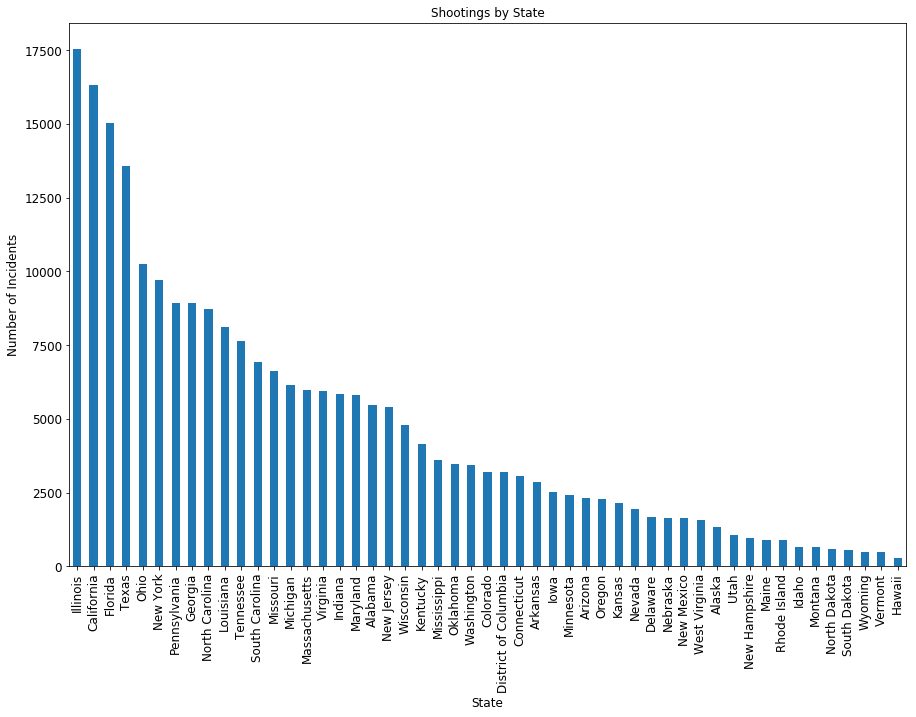

In [10]:
#Try graphing some of the data- state
import matplotlib.pyplot as plt
ax = df['state'].value_counts().plot(kind='bar', title ="Shootings by State", figsize=(15, 10),
                                     legend=False, fontsize=12)
ax.set_xlabel("State", fontsize=12)
ax.set_ylabel("Number of Incidents", fontsize=12)
plt.show()

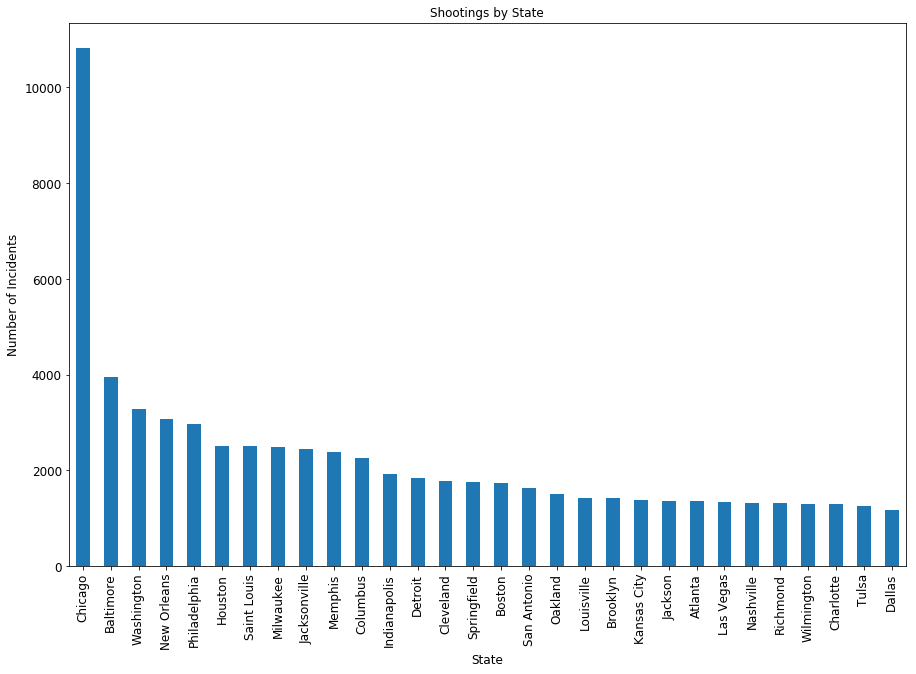

In [11]:
ax2 = df['city_or_county'].value_counts().nlargest(30).plot(kind='bar', title ="Shootings by State", figsize=(15, 10), legend=False, fontsize=12)
ax2.set_xlabel("State", fontsize=12)
ax2.set_ylabel("Number of Incidents", fontsize=12)
plt.show()

In [13]:
# Find whether or not a city has an abnormal amount of shootings based on proportion to population.
# This will write the dictionary to a file so the dictionary can be loaded instead of being recreated each time.

# def createStateDict(df):
#     print("here")
#     stateDict = {}
#     for index in range(len(df)):
#         currentCity = df['city_or_county'][index]
#         currentState = df['state'][index]
        
#         # Creating a dictionary of dictionaries
#         # Adds up the number of people killed in each city for each state
#         if currentState not in stateDict:
#             stateDict[currentState] = {}
#         elif currentCity not in stateDict[currentState]:
#             cityDF = df[df.city_or_county == currentCity]
#             cityDF['population'] = cityDF['population'].replace(np.nan, 0)
#             total_population = max(cityDF['population'])
#             if total_population == 0:
#                 continue
#             print(currentCity, currentState, len(cityDF), len(cityDF) / total_population)
#             stateDict[currentState][currentCity] = len(cityDF) / total_population
    
#     avgDict = {}
#     for state in stateDict:
#         total = 0
#         numCities = 0
#         for city in stateDict[state]:
#             total += stateDict[state][city]
#             numCities += 1
#         if numCities > 0:
#             avgDict[state] = total / numCities
# #     print(list(avgDict.values()))
    
#     return avgDict

# stateAvgs = createStateDict(df)

# r = json.dumps(stateAvgs)
# file = open("./shootingProportions.txt", "w")
# file.write(r)
# file.close()

In [15]:
# This pulls data from file instead of rerunning above code (which takes awhile).
file = open("./shootingProportions.txt", "r")
averages = file.read()
file.close()
averages = json.loads(averages)
df2 = DataFrame({"shootings_per_population": list(averages.values())}, index=averages.keys())

In [16]:
# Add average incomes to the 
df2['average_income'] = np.nan
for state in df2.index:
    df2['average_income'][state] = df[df['state'] == state]['income'].mean()

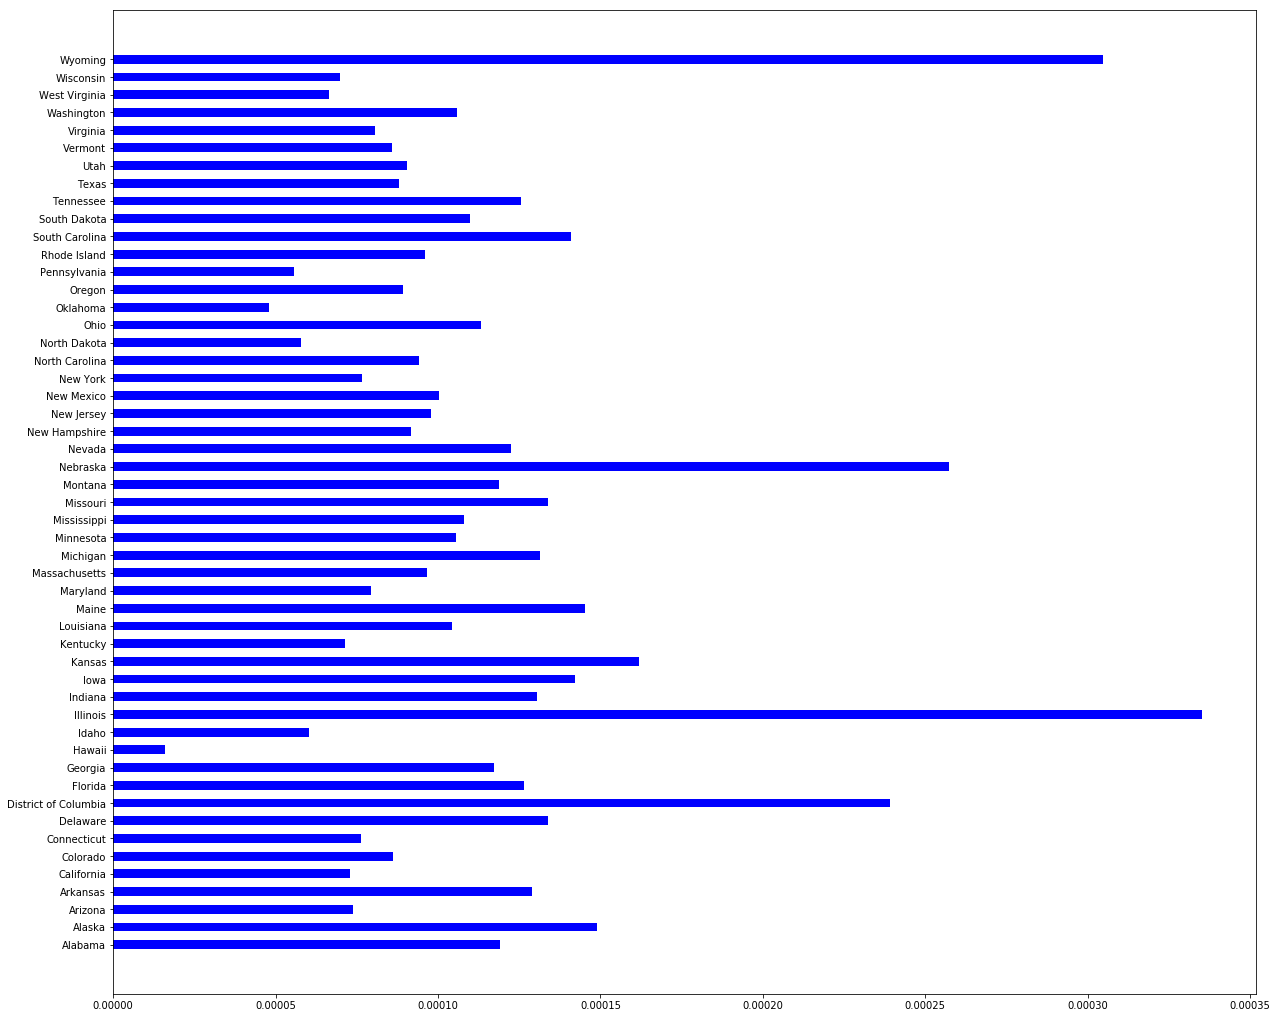

In [18]:
width = 0.5
fig, ax = plt.subplots()
y = df2['shootings_per_population']
ind1 = list(df2.index)
ax.barh(ind1, y, width, color="blue")
fig.tight_layout()
fig.set_size_inches(24, 16)


plt.show()
plt.clf()

In [19]:
df2

,shootings_per_population,average_income
Michigan,0.000132,47904.564439
Wisconsin,0.000070,48874.768485
Tennessee,0.000125,43912.352972
Virginia,0.000081,54517.476085
Ohio,0.000113,52092.603625
Arizona,0.000074,50620.947505
Florida,0.000127,47320.601105
Texas,0.000088,52096.580477
New Jersey,0.000098,66079.815775
Pennsylvania,0.000056,48429.129183


In [22]:
print(df2.nlargest(10, ['shootings_per_population', 'average_income']))
print(df2['shootings_per_population'].mean())
print(max(df2['average_income']), min(df2['average_income']), df2['average_income'].mean())

                      shootings_per_population  average_income
Illinois                              0.000335    55169.759022
Wyoming                               0.000305    57795.791262
Nebraska                              0.000257    72269.000000
District of Columbia                  0.000239    75506.000000
Kansas                                0.000162    57532.240822
Alaska                                0.000149    81476.051607
Maine                                 0.000145    57707.669789
Iowa                                  0.000142    48231.065436
South Carolina                        0.000141    45099.183915
Delaware                              0.000134    46834.371734
0.0001143209287897072
81476.05160662123 41437.185442574984 55570.03093417813


In [23]:
# # Find whether or not a city has an abnormal amount of shootings based on average of all cities using the central 
# # limit theorem.
# # Possibly normalize data by having number of shootings be a proportion of total population?
# # df1 = df.truncate(before=0, after=100000)

# def createStateDict(df):
#     stateDict = {}
#     for index in range(len(df)):
#         currentCity = df['city_or_county'][index]
#         currentState = df['state'][index]
        
#         # Creating a dictionary of dictionaries
#         # Adds up the number of people killed in each city for each state
#         if currentState not in stateDict:
#             stateDict[currentState] = {}
#         elif currentCity not in stateDict[currentState]:
#             stateDict[currentState][currentCity] = df['n_killed'][index]
#         else:
#             stateDict[currentState][currentCity] += df['n_killed'][index]
    
    
#     averageStateFatalities = {}
    
#     # find average of each state
#     for state in stateDict:
#         total = 0
#         numCities = 0
#         average = 0
#         for city in stateDict[state]:
#             numCities += 1
#             # replacing the total n_killed with the average for this city
#             stateDict[state][city] = stateDict[state][city] / len(df[df.city_or_county == city])
#             total += stateDict[state][city]
#         if(numCities > 0):
#             print(state, total, numCities)
#             average = total / numCities
        
        
#         averageStateFatalities[state] = round(average,2)
    
#     print(averageStateFatalities)
#     return averageStateFatalities, stateDict


# avgStateFatalities, stateDict = createStateDict(df)

In [24]:
file = open("./avgStateFatalities.txt", "r")
averages = file.read()
file.close()
avgStateFatalities = json.loads(averages)

file = open("./stateDict.txt", "r")
states = file.read()
file.close()
stateDict = json.loads(states)

In [25]:
def determineAbnormalAmountOfShootings(avgStateFatalities, stateDict, state, city):
    mu = avgStateFatalities[state]
    variance = 0
    numCities = 0
    print(len(stateDict[state]))
    
    # for loop to calculate the variance for this state
    for currentCity in stateDict[state]:
        numCities += 1
#         print(currentCity, stateDict[state][currentCity], avgStateFatalities[state])
        variance = variance + (stateDict[state][currentCity] - avgStateFatalities[state])**2
    variance = variance / (numCities - 1)
    
    # take a random sample from the dataframe with a length of numInstances
    # if numInstances exceeds total instances, then just use the total
    stateDF = df[df.city_or_county == city]
    try:
        sampleDF = stateDF.sample(n=int(len(stateDF)*.75))
    except ValueError:
        sampleDF = stateDF
    
    # take the mean of this random sample 
    yBar = sampleDF['n_killed'].mean()
    n = len(sampleDF)
#     print(df[df.state == state])
#     print(sampleDF)
    U = math.sqrt(n)*(yBar-mu)/math.sqrt(variance)
    print(n, yBar, mu, variance, U)
    rv = stats.norm()
    print(rv.cdf(U))
    

determineAbnormalAmountOfShootings(avgStateFatalities, stateDict, "Texas", "Houston")

871
1875 0.4608 0.44 1.081500982076884 0.8660650477956691
0.8067727543697562


In [26]:
# DataFrame for states
states_df = DataFrame(index=df['state'].unique(), columns=['Total killed', 'Total injured', 'Gun Laws', 'Total incidents'])
states_df['Total killed'] = states_df['Total killed'].fillna(0)
states_df['Total injured'] = states_df['Total injured'].fillna(0)
states_df['Total incidents'] = states_df['Total incidents'].fillna(0)

In [27]:
# Dictionary for each gender and type
gender_type_dict = {"Male-Suspect": 0, "Male-Victim": 0, "Female-Suspect": 0, "Female-Victim": 0}

for i in range(0, len(df), 1):
    # Create lists for genders and types
    genderList = re.split("\d*[:|]\s*", df['participant_gender'][i])
    typeList = re.split("\d*[:|]", df['participant_type'][i])
    
    # Remove empty spaces from lists
    genderList = list(filter(lambda x: x != '', genderList))
    typeList = list(filter(lambda x: x != '', typeList))

    # Get total number of incidents for each gender and type
    for j in range(0, max(len(genderList), len(typeList)), 1):
        # If one list is greater than the other, use the first element
        if j >= len(genderList):
            part_gender = genderList[0]
        else:
            part_gender = genderList[j]
        if j >= len(typeList):
            part_type = typeList[0]
        else:
            part_type = typeList[j]
        
        # Skip entries with Unknowns
        if part_gender == "Unknown" or part_type == "Unknown":
            continue
        
        # Increment corresponding gender type in dictionary
        if part_gender == "Male":
            if part_type == "Subject-Suspect":
                gender_type_dict['Male-Suspect'] = gender_type_dict['Male-Suspect'] + 1
            else:
                gender_type_dict['Male-Victim'] = gender_type_dict['Male-Victim'] + 1
        else:
            if part_type == "Subject-Suspect":
                gender_type_dict['Female-Suspect'] = gender_type_dict['Female-Suspect'] + 1
            else:
                gender_type_dict['Female-Victim'] = gender_type_dict['Female-Victim'] + 1
            
print("Dictionary: ", gender_type_dict)
#print("Total: ", gender_type_dict.values.sum())

Dictionary:  {'Male-Suspect': 185568, 'Male-Victim': 160809, 'Female-Suspect': 13695, 'Female-Victim': 32251}


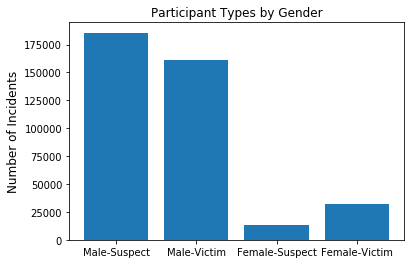

In [28]:
# Graph all gender types and their number of incidents
total = sum(list(gender_type_dict.values()))
plt.bar(range(len(gender_type_dict)), list(gender_type_dict.values()), align='center')
plt.xticks(range(len(gender_type_dict)), list(gender_type_dict.keys()))
plt.title("Participant Types by Gender", fontsize=12)
plt.ylabel("Number of Incidents", fontsize=12)

plt.show()

In [29]:
# Get total killed, injured, and incidents per state
for state in df['state'].unique():
    states_df['Total killed'].loc[state] = df.loc[df['state']==state, 'n_killed'].sum()
    states_df['Total injured'].loc[state] = df.loc[df['state']==state, 'n_injured'].sum()
    states_df['Total incidents'].loc[state] = df['state'].value_counts().loc[state]

In [30]:
# Total gun laws in each state (per statefirearmslaws.org, 2018)
states_df['Gun Laws'].loc["Texas"] = 18
states_df['Gun Laws'].loc["Hawaii"] = 79
states_df['Gun Laws'].loc["Alaska"] = 3
states_df['Gun Laws'].loc["New Mexico"] = 10
states_df['Gun Laws'].loc["Arizona"] = 8
states_df['Gun Laws'].loc["California"] = 107
states_df['Gun Laws'].loc["Nevada"] = 21
states_df['Gun Laws'].loc["Utah"] = 13
states_df['Gun Laws'].loc["Colorado"] = 30
states_df['Gun Laws'].loc["Oregon"] = 37
states_df['Gun Laws'].loc["Wyoming"] = 6
states_df['Gun Laws'].loc["Washington"] = 43
states_df['Gun Laws'].loc["Idaho"] = 2
states_df['Gun Laws'].loc["Montana"] = 4
states_df['Gun Laws'].loc["North Dakota"] = 10
states_df['Gun Laws'].loc["South Dakota"] = 5
states_df['Gun Laws'].loc["Nebraska"] = 22
states_df['Gun Laws'].loc["Minnesota"] = 41
states_df['Gun Laws'].loc["Iowa"] = 24
states_df['Gun Laws'].loc["Wisconsin"] = 23
states_df['Gun Laws'].loc["Michigan"] = 21
states_df['Gun Laws'].loc["Illinois"] = 65
states_df['Gun Laws'].loc["Kansas"] = 4
states_df['Gun Laws'].loc["Oklahoma"] = 9
states_df['Gun Laws'].loc["Missouri"] = 2
states_df['Gun Laws'].loc["Arkansas"] = 11
states_df['Gun Laws'].loc["Indiana"] = 12
states_df['Gun Laws'].loc["Ohio"] = 16
states_df['Gun Laws'].loc["Pennsylvania"] = 37
states_df['Gun Laws'].loc["West Virginia"] = 18
states_df['Gun Laws'].loc["New York"] = 76
states_df['Gun Laws'].loc["Vermont"] = 6
states_df['Gun Laws'].loc["New Hampshire"] = 9
states_df['Gun Laws'].loc["Maine"] = 11
states_df['Gun Laws'].loc["Massachusetts"] = 101
states_df['Gun Laws'].loc["Rhode Island"] = 53
states_df['Gun Laws'].loc["Connecticut"] = 90
states_df['Gun Laws'].loc["New Jersey"] = 75
states_df['Gun Laws'].loc["Delaware"] = 40
states_df['Gun Laws'].loc["Maryland"] = 64
states_df['Gun Laws'].loc["Virginia"] = 13
states_df['Gun Laws'].loc["Kentucky"] = 7
states_df['Gun Laws'].loc["Tennessee"] = 22
states_df['Gun Laws'].loc["North Carolina"] = 30
states_df['Gun Laws'].loc["South Carolina"] = 12
states_df['Gun Laws'].loc["Georgia"] = 6
states_df['Gun Laws'].loc["Florida"] = 21
states_df['Gun Laws'].loc["Alabama"] = 10
states_df['Gun Laws'].loc["Mississippi"] = 2
states_df['Gun Laws'].loc["Louisiana"] = 13

In [31]:
states_df

,Total killed,Total injured,Gun Laws,Total incidents
Michigan,1588,2990,21,6136
Wisconsin,862,2117,23,4787
Tennessee,1824,4478,22,7626
Virginia,1459,3566,13,5949
Ohio,2508,5703,16,10244
Arizona,1094,1096,8,2328
Florida,3909,7072,21,15029
Texas,5046,6106,18,13577
New Jersey,1168,2540,75,5387
Pennsylvania,2395,5056,37,8929


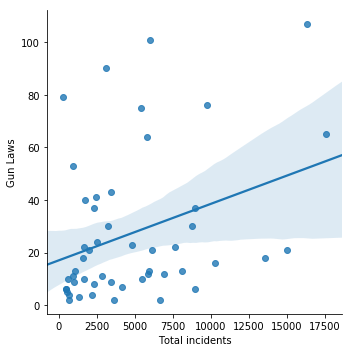

In [32]:
sns.lmplot(x='Total incidents', y='Gun Laws', data=states_df)
plt.show()

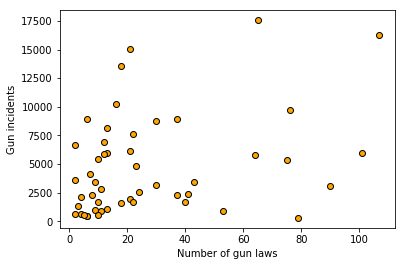

In [33]:
plt.scatter(x=states_df['Gun Laws'],y=states_df['Total incidents'],
            color="orange", edgecolors="black")

plt.xlabel("Number of gun laws")
plt.ylabel("Gun incidents")

plt.show()

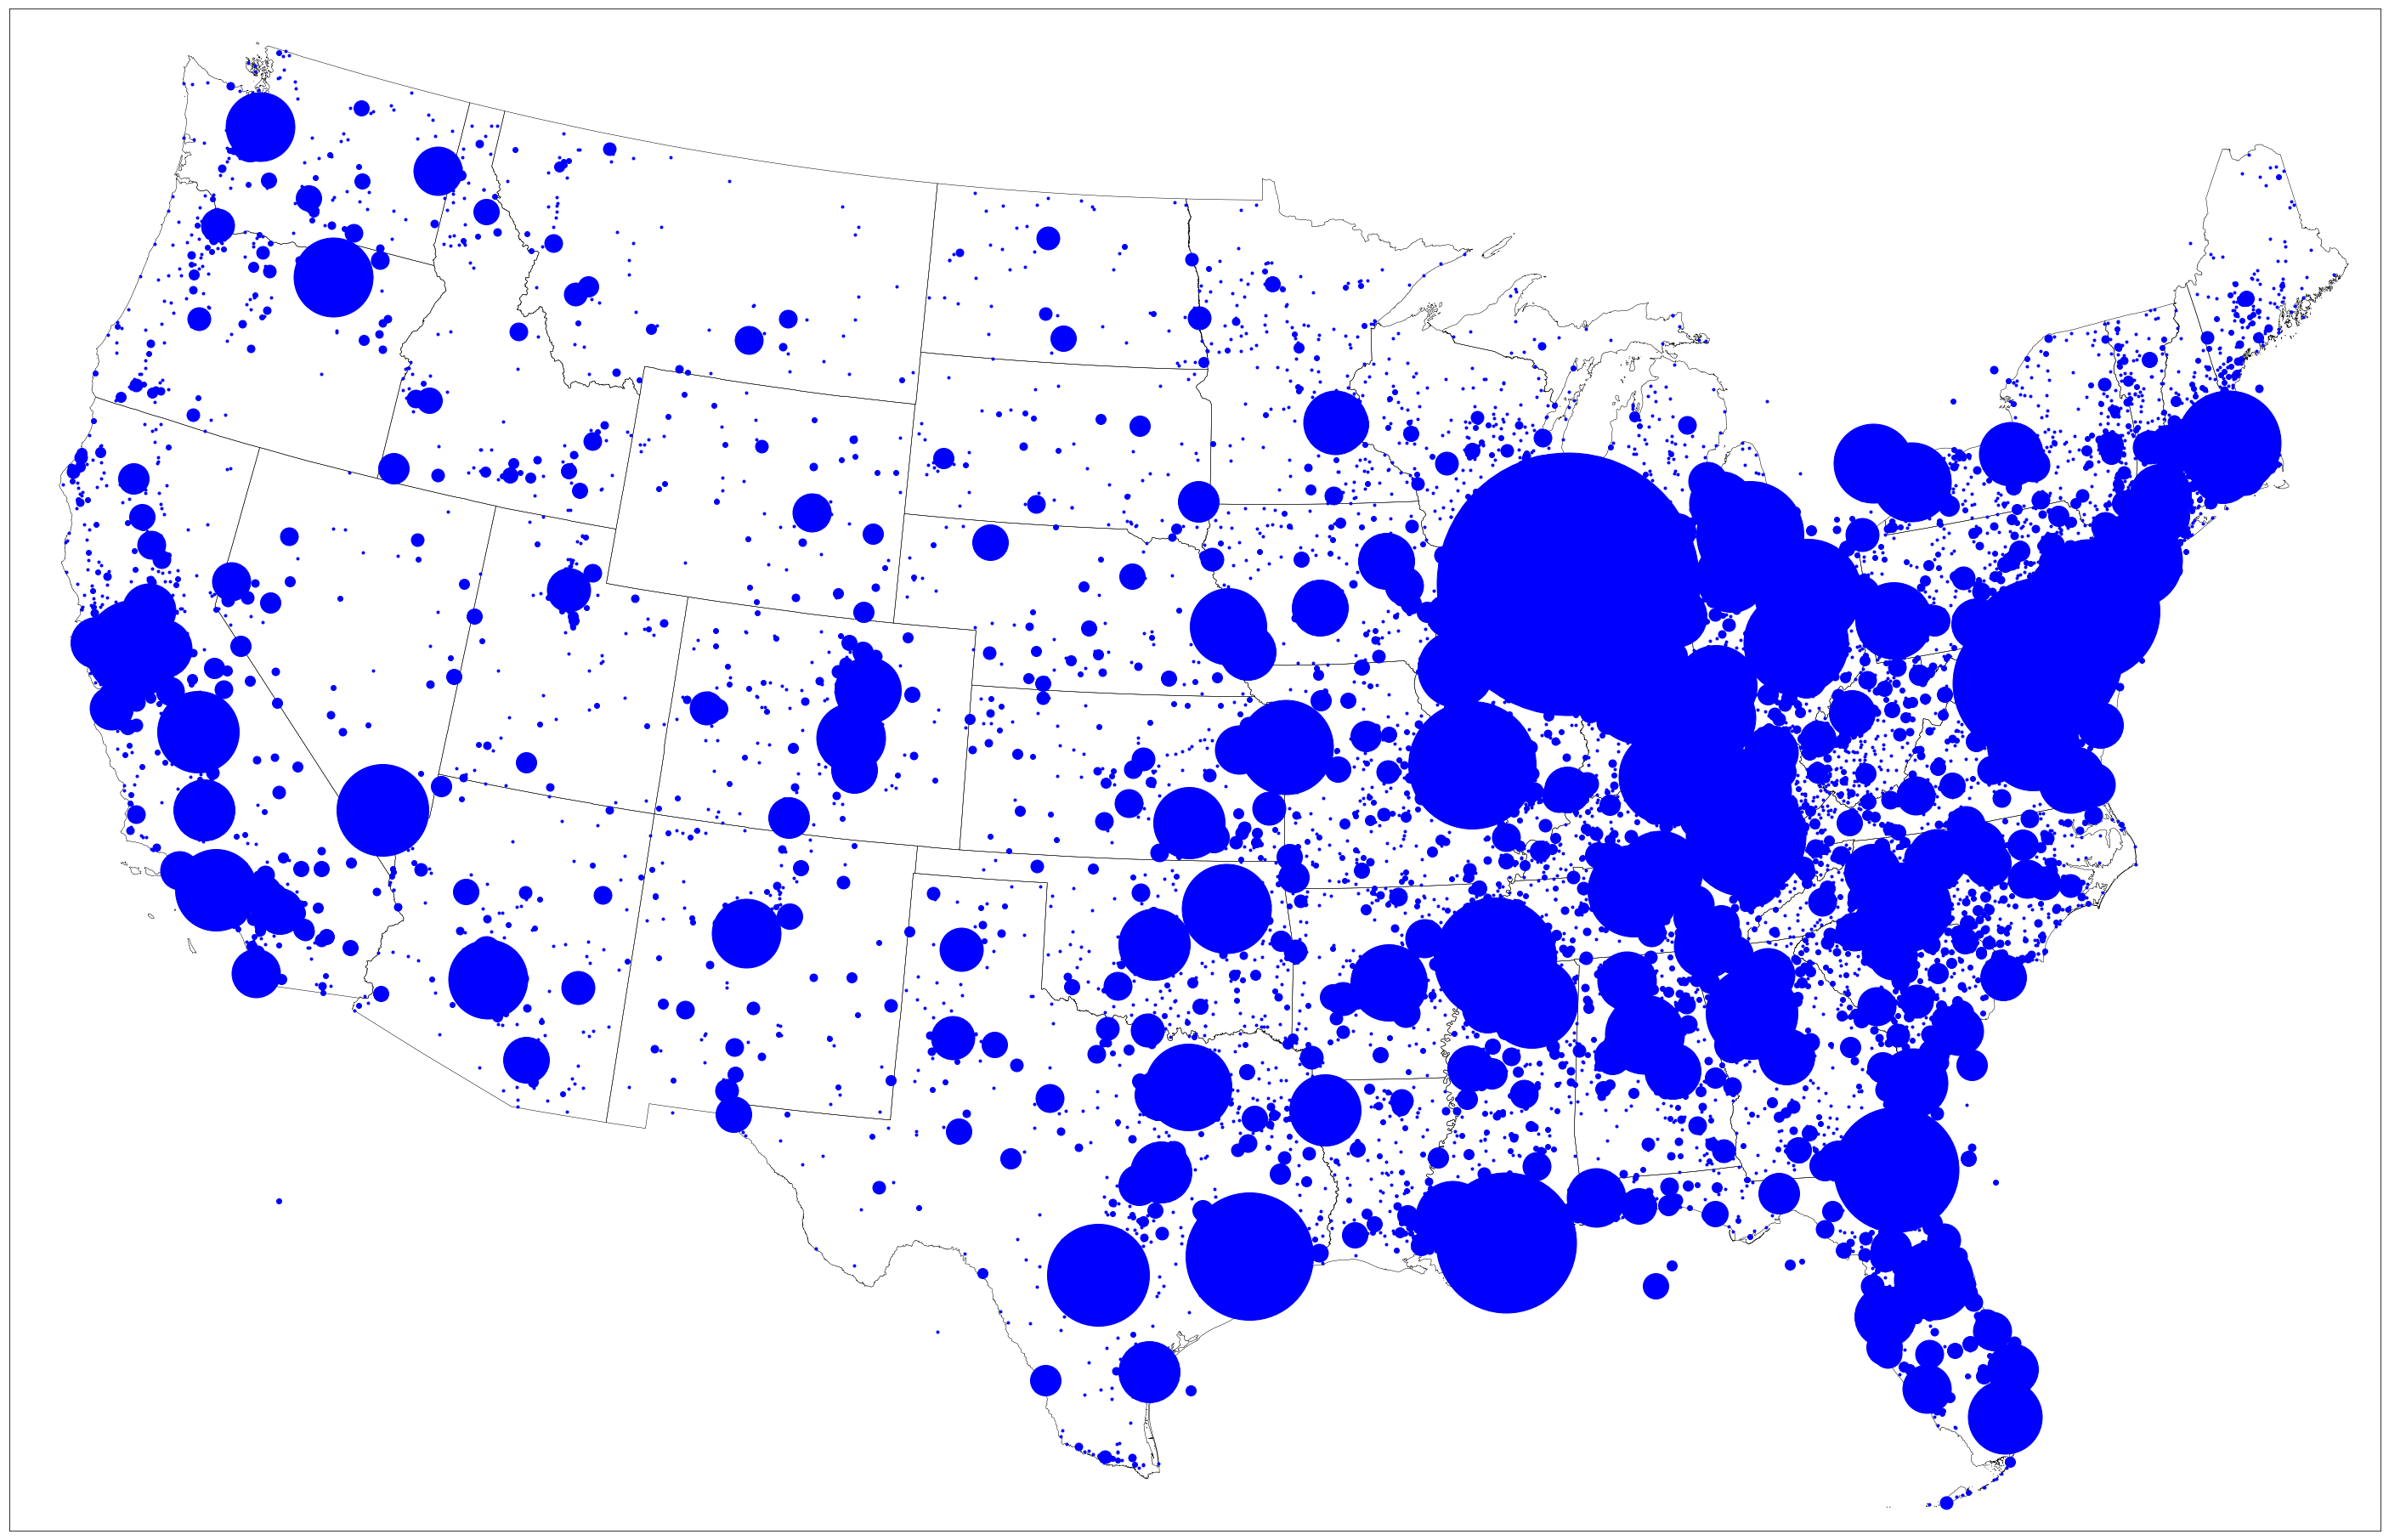

In [35]:
## ALL GUNSHOT VICTIMS
scale = 3
unitedstates_map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
                           projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
unitedstates_map.readshapefile('./cb_2017_us_state_500k/cb_2017_us_state_500k', 'USA', drawbounds=True)

city_group = df.groupby(df.city_or_county)
mean_lat_long_cities = city_group[['latitude', 'longitude']].agg(np.mean)
city_incident_count = city_group.size()
city_incident_count.name = 'count'

incident_points = pd.concat([city_incident_count, mean_lat_long_cities], axis=1)

for point in incident_points.itertuples():
    long, lat = unitedstates_map(point.longitude, point.latitude)
    unitedstates_map.plot(long, lat, marker='o', color='Blue', markersize=int(math.sqrt(point.count)) * scale)
fig = plt.gcf()
fig.set_size_inches(50, 50)
plt.show()

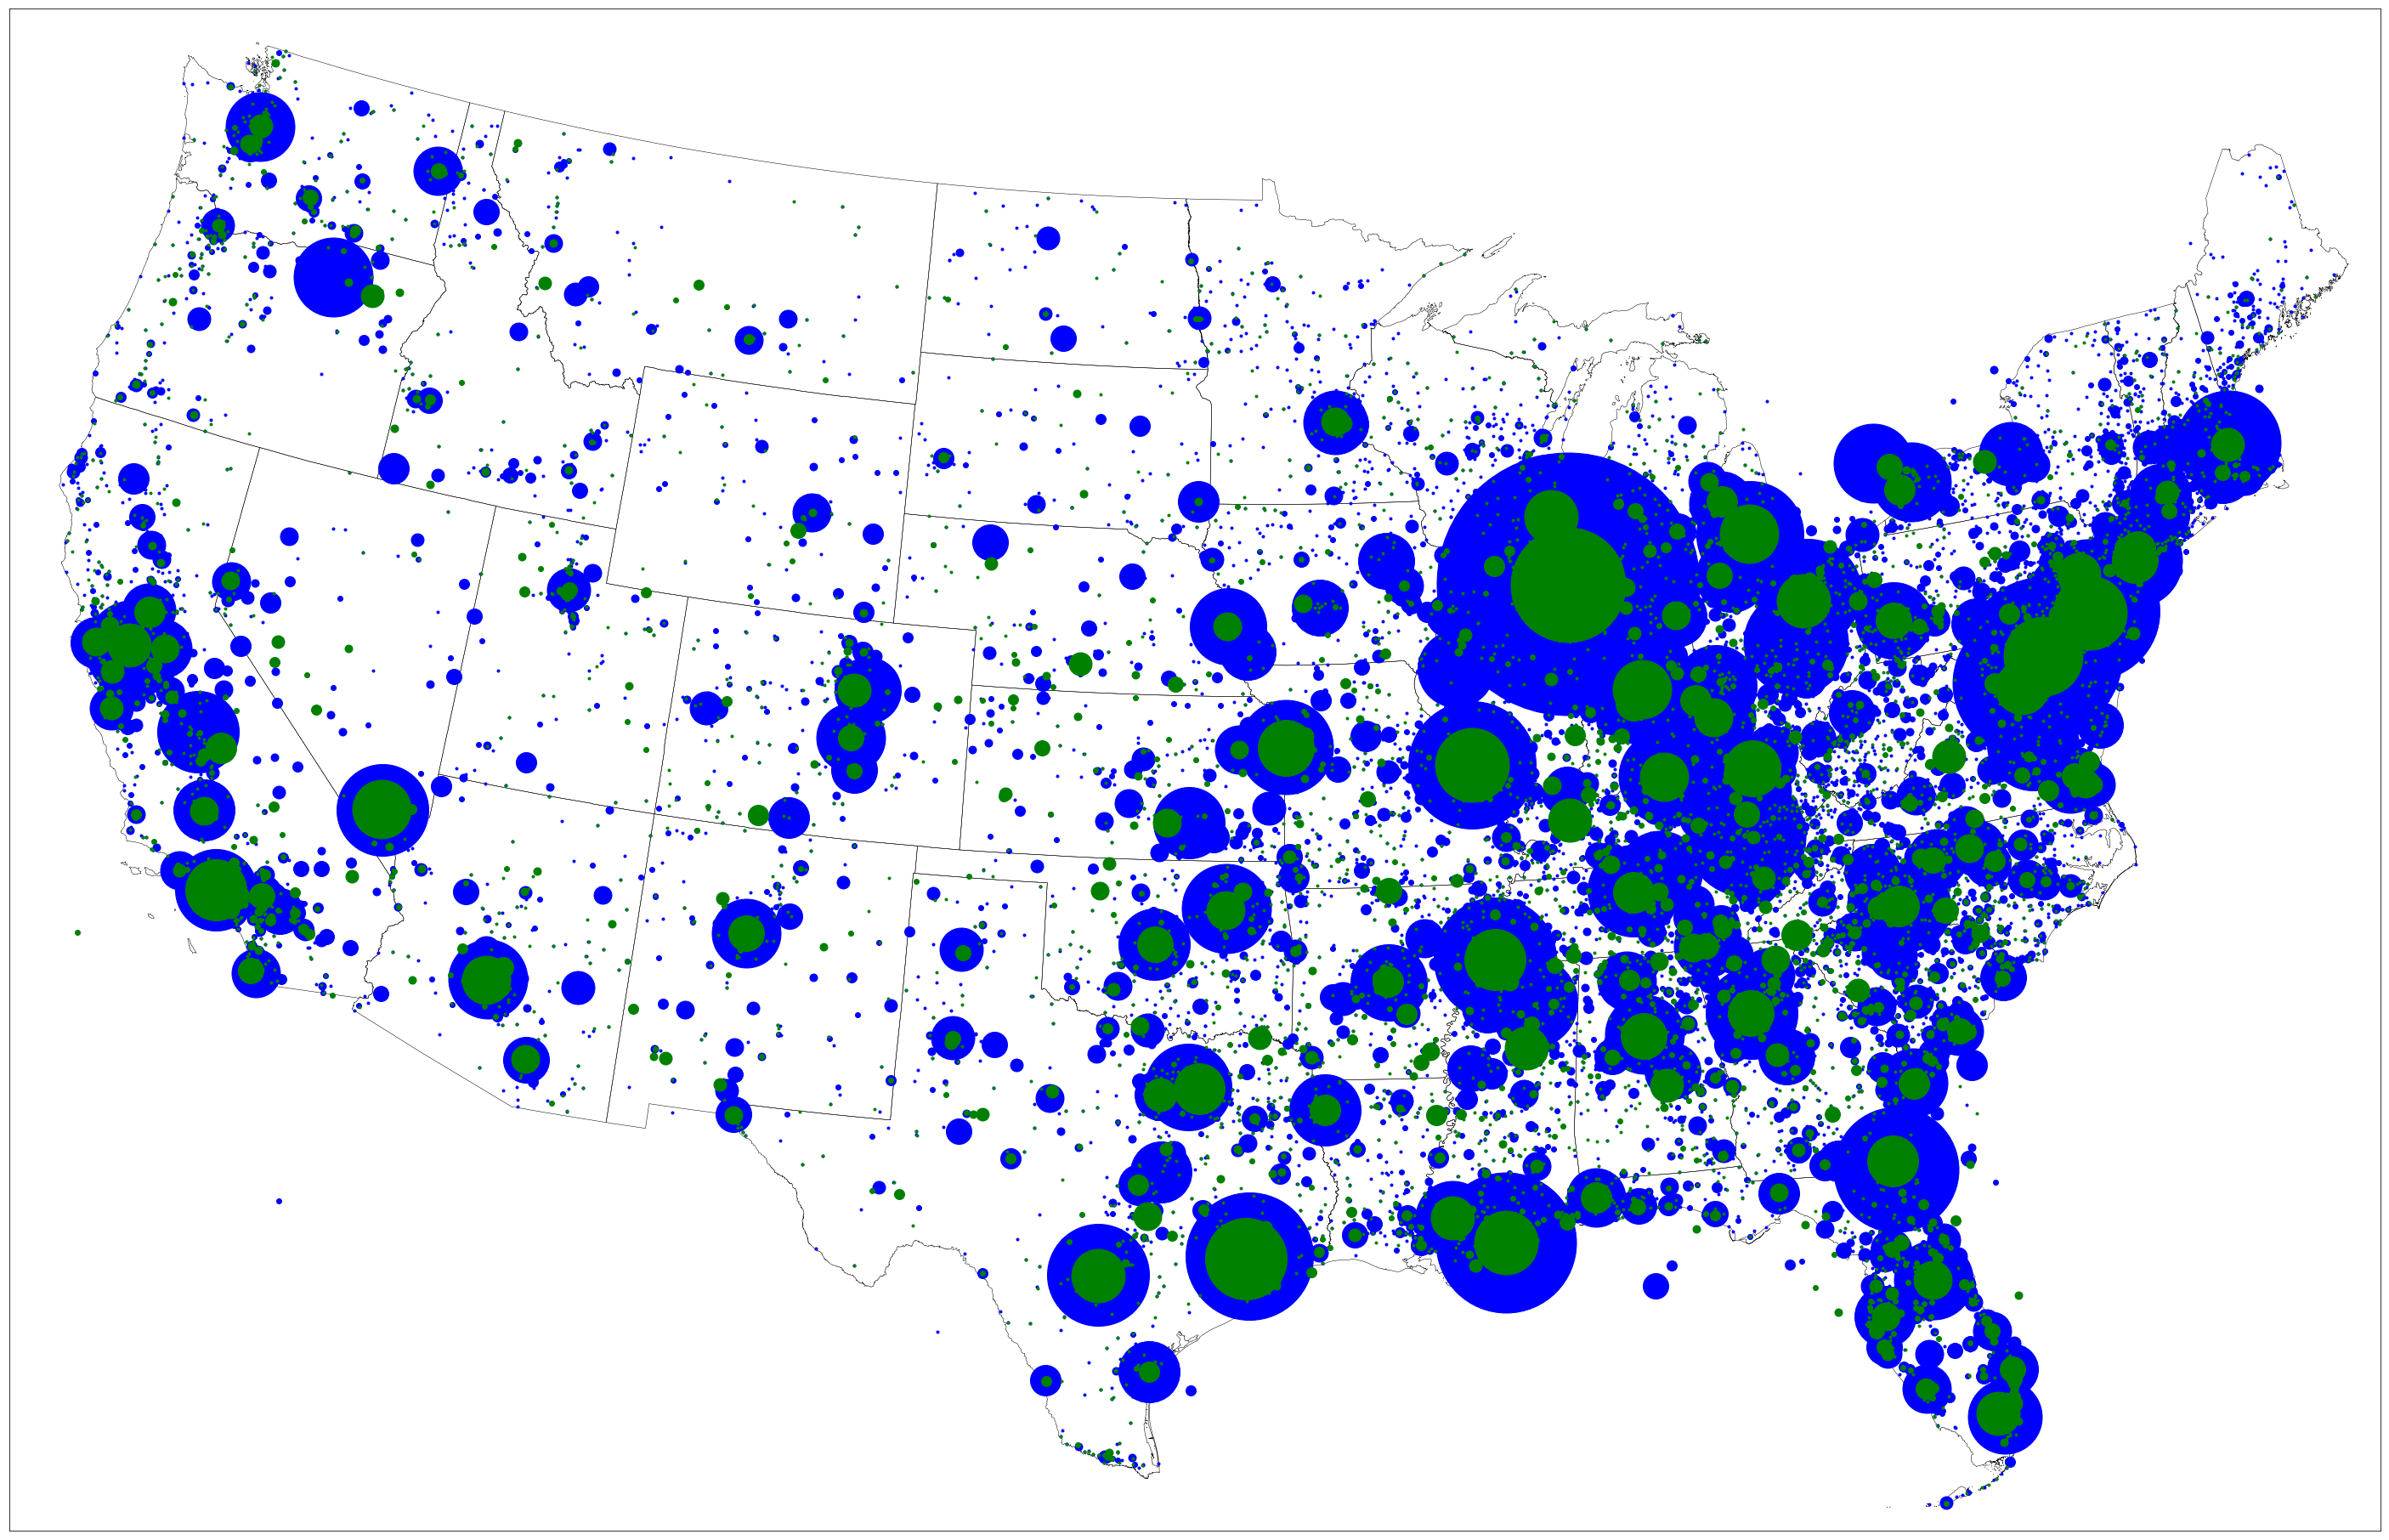

In [36]:
## ALL INCIDENTS WITH SUICIDES/POSSIBLE SUICIDES AS GREEN
scale = 3
unitedstates_map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
                           projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
unitedstates_map.readshapefile('./cb_2017_us_state_500k/cb_2017_us_state_500k', 'USA', drawbounds=True)


suicides = df[df.incident_characteristics.str.contains('suicide').fillna(False)]
suicide_group = suicides.groupby(suicides.city_or_county)
suicide_lat_long_group = suicide_group[['latitude', 'longitude']].agg(np.mean)
suicide_incident_count = suicide_group.size()
suicide_incident_count.name = 'count'
suicide_incident_points = pd.concat([suicide_incident_count, suicide_lat_long_group], axis=1)

non_suicides = df[~df.incident_characteristics.str.contains('suicide').fillna(False)]
non_suicides_group = non_suicides.groupby(non_suicides.city_or_county)
non_suicide_lat_long_group = non_suicides_group[['latitude', 'longitude']].agg(np.mean)
non_suicide_incident_count = non_suicides_group.size()
non_suicide_incident_count.name = 'count'
non_suicide_incident_points = pd.concat([city_incident_count, mean_lat_long_cities], axis=1)

    
for point in non_suicide_incident_points.itertuples():
    long, lat = unitedstates_map(point.longitude, point.latitude)
    unitedstates_map.plot(long, lat, marker='o', color='Blue', markersize=int(math.sqrt(point.count)) * scale)
    
for point in suicide_incident_points.itertuples():
    long, lat = unitedstates_map(point.longitude, point.latitude)
    unitedstates_map.plot(long, lat, marker='o', color='Green', markersize=int(math.sqrt(point.count)) * scale)
    
fig = plt.gcf()
fig.set_size_inches(50, 50)
plt.show()